# Dimensionality reduction

The dataset has increased its variables considerably due to the new generated ones, feature engineering and node embeddings. In order to reduce its complexity and avoid overfitting, it is ideal to apply a dimensionality reduction technique.

Recursive Feature Extraction is a dimensionality reduction technique that evaluate the models with the best combination of features, in order to keep only those features that improve the model's performance. It can be applied with cross validation to avoid overfitting during the process. The chosen model to apply RFE is XGBoost Classifier since it can capture complex relationships on the data, very helpful to not discard features that have interaction with other ones.

## Preparing environment

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import sys
sys.path.append('../high_performance_employee_resign_prediction')
from utils import paths

## Importing data

In [40]:
train_df = pd.read_csv(paths.data_processed_dir('train_featured.csv'))
test_df = pd.read_csv(paths.data_processed_dir('test_featured.csv'))

train_red_df = pd.read_csv(paths.data_processed_dir('train_red_featured.csv'))
test_red_df = pd.read_csv(paths.data_processed_dir('test_red_featured.csv'))

In [ ]:
# Extracting node embeddings to not affect them

embeddings_columns = [col for col in train_df.columns.tolist() if 'embedding' in col]

embeddings_train = train_df[embeddings_columns]
embeddings_test = test_df[embeddings_columns]

train_df = train_df.drop(columns=embeddings_columns)
test_df = test_df.drop(columns=embeddings_columns)
train_red_df = train_red_df.drop(columns=embeddings_columns)
test_red_df = test_red_df.drop(columns=embeddings_columns)

In [42]:
# Extracting ids and target features
ids = ['id_employee', 'id_last_boss']

ids_train = train_df[ids]
ids_test = test_df[ids]

y = train_df['resign']

train_df.drop(columns=ids, inplace=True)
train_df.drop(columns=['resign'], inplace=True)
train_red_df.drop(columns=ids, inplace=True)
train_red_df.drop(columns=['resign'], inplace=True)
test_df.drop(columns=ids, inplace=True)
test_red_df.drop(columns=ids, inplace=True)

In [43]:
# Converting categorical columns

cat_cols = ['seniority', 'work_modality', 'gender', 'recruitment_channel', 'marital_estatus', 
            'join_year', 'join_month', 'performance', 'join_age_group', 'work_modality_boss', 
            'gender_boss', 'recruitment_channel_boss', 'marital_estatus_boss', 'join_year_boss', 'join_month_boss', 
            'performance_boss', 'join_age_group_boss', 'joined_after_boss', 'younger_than_boss']

red_cat_cols = [col for col in cat_cols if col in train_red_df.columns]

train_df[cat_cols] = train_df[cat_cols].astype('category')
test_df[cat_cols] = test_df[cat_cols].astype('category')
train_red_df[red_cat_cols] = train_red_df[red_cat_cols].astype('category')
test_red_df[red_cat_cols] = test_red_df[red_cat_cols].astype('category')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)

## Applying RFE

In [ ]:
# Initializing XGBoost Classifier

xgb = XGBClassifier(random_state=42,
                    objective='binary:logistic',
                    eval_metric='logloss', 
                    enable_categorical=True,
                    booster='dart',
                    tree_method='hist',
                    max_depth=6,
                    n_estimators=1000,
                    learning_rate=0.01,
                    colsample_bytree=0.8,
                    reg_alpha=0.1,
                    reg_lambda=1.0, 
                    early_stopping_rounds=50
                    )

xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [46]:
feature_importances = xgb.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': train_df.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

In [47]:
feature_importance_df

,feature,importance
4,gender,0.083815
51,Abs(performance_score)/performance_score,0.079747
19,gender_boss,0.048776
44,gender_Mujer*gender_boss_Mujer,0.036954
56,seniority_2*Abs(psi_score_boss),0.035880
...,...,...
34,age_diff,0.006158
16,work_modality_boss,0.005071
30,join_age_group_boss,0.004650
15,join_age_group,0.003422


In [48]:
# Applying RFE manually:

feat_number = list(range(1, feature_importance_df.shape[0] + 1))
scores = []

for i in feat_number:
    cols = list(feature_importance_df.iloc[:i, 0])
    
    xgb = XGBClassifier(random_state=42,
                    objective='binary:logistic',
                    eval_metric='logloss', 
                    enable_categorical=True,
                    booster='dart',
                    tree_method='hist',
                    max_depth=6,
                    n_estimators=1000,
                    learning_rate=0.01,
                    colsample_bytree=0.8,
                    reg_alpha=0.1,
                    reg_lambda=1.0, 
                    early_stopping_rounds=50
                    )

    xgb.fit(X_train[cols], y_train, eval_set=[(X_test[cols], y_test)], verbose=False)
    f1_cols = f1_score(xgb.predict(X_test[cols]), y_test)
    scores.append(f1_cols)

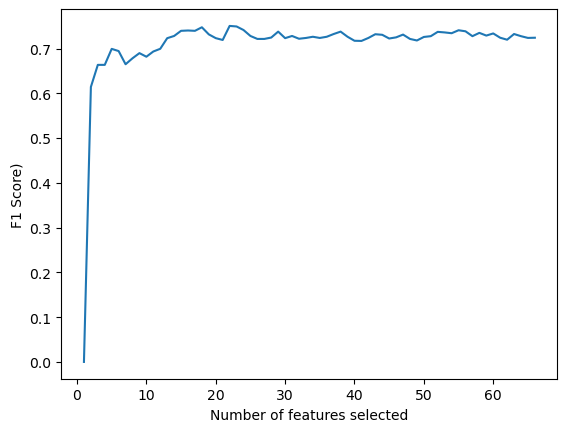

In [ ]:
# Plotting F1 score vs Number of features

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("F1 Score)")
plt.plot(feat_number, scores)
plt.show()

In [ ]:
# Saving selected features

selected_features = list(feature_importance_df.iloc[:scores.index(max(scores)), 0])
reduced_train = pd.concat([ids_train, train_df[selected_features], embeddings_train, y], axis=1)
reduced_test = pd.concat([ids_test, test_df[selected_features], embeddings_test], axis=1)

In [58]:
selected_features

['gender',
 'Abs(performance_score)/performance_score',
 'gender_boss',
 'gender_Mujer*gender_boss_Mujer',
 'seniority_2*Abs(psi_score_boss)',
 'gender_boss_Mujer*Abs(join_age_boss)',
 'performance_score',
 'gender_Mujer*recruitment_channel_PortalWeb',
 'gender_Mujer*marital_estatus_Soltero',
 'seniority',
 'gender_Mujer*low_health_days',
 'recruitment_channel',
 'join_year',
 'performance',
 'office_distance_boss**2/boss_employees_in_charge',
 'low_health_days',
 'marital_estatus',
 'marital_estatus_Soltero*Abs(psi_score)',
 'join_month_boss',
 'performance_score_boss*recruitment_channel_boss_PortalWeb',
 'join_year_boss']

In [ ]:
# Saving reduced data

reduced_train.to_csv(paths.data_processed_dir('reduced_train.csv'), index=False)
reduced_test.to_csv(paths.data_processed_dir('reduced_test.csv'), index=False)